In [1]:
using Revise
using Pkg
Pkg.develop(path="/home/stephenz/stephenz/locaTE.jl")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


In [2]:
using NPZ
using locaTE
using NearestNeighbors
using Graphs
using GraphSignals
using SparseArrays
using LinearAlgebra

In [3]:
using Plots
using StatsBase

In [110]:
X = npzread("X.npy");
X_pca = npzread("X_pca.npy");
X_umap = npzread("X_umap.npy");
P = npzread("P_unitvelo.npy");
dpt = npzread("dpt.npy");
C = npzread("C.npy");

In [117]:
P = (0.99P + 0.01I);

In [118]:
# construct kNN and Laplacian
kdtree = KDTree(X_pca')
idxs, dists = knn(kdtree, X_pca', 25);
A = spzeros(size(X_pca, 1), size(X_pca, 1));
for (i, j) in enumerate(idxs)
    A[i, j] .= 1.0
end
L = sparse(normalized_laplacian(max.(A, A'), Float64));

In [119]:
using Distances
using OptimalTransport
C = Distances.pairwise(SqEuclidean(), X_pca[:, 1:5]')
R = quadreg(ones(size(X, 1)), ones(size(X, 1)), C, 5*mean(C));

In [120]:
# p = Array(R[2500, :])
# scatter(X_umap[sortperm(p), 1], X_umap[sortperm(p), 2], marker_z = sort(p), clim = (0, quantile(p, 0.999)), alpha = 0.25, markerstrokewidth = 0)

In [121]:
P_sp = sparse(P)
QT_sp = sparse(to_backward_kernel(P))
R_sp = sparse(R);

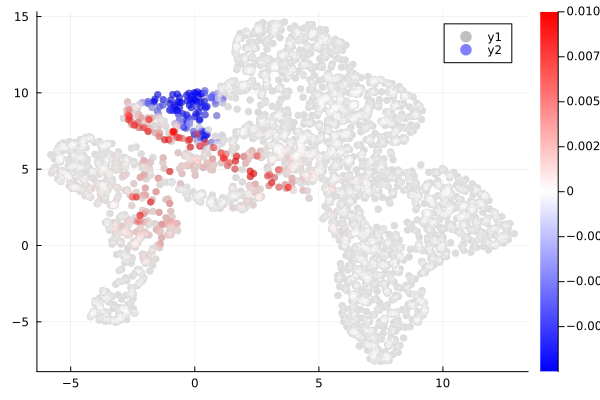

In [131]:
p0 = R[sortperm(dpt)[500], :]
p1 = vec(p0' * P)
p = p1 - p0
scatter(X_umap[:, 1], X_umap[:, 2], markerstrokewidth = 0, color = :grey, alpha = 0.5)
scatter!(X_umap[sortperm(p), 1], X_umap[sortperm(p), 2], marker_z = sort(p), markerstrokewidth = 0, alpha = 0.5, color = :bwr, clim = (-0.01, 0.01))

In [132]:
using Discretizers
alg = DiscretizeBayesianBlocks()
disc = locaTE.discretizations_bulk(X; alg = alg);

In [ ]:
TE = estimate_TE_cu(X, 1:size(X, 2), 1:size(X, 2), Array(P_sp), Array(QT_sp), Array(R_sp), N_blocks = 1, disc = disc);

In [134]:
TE_clr = apply_wclr(TE, size(X, 2))
TE_clr[isnan.(TE_clr)] .= 0;

In [135]:
using CUDA

In [136]:
L_cu = cu(Array(L));
G = fitsp(cu(TE_clr), L_cu, λ1 = 25.0, λ2 = 0.001, maxiter = 100);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
[ Info: ΔX = 1.0364804089651536e-6, ΔZ = 0.00014040325561929037, ΔW = 0.0001571891881091761
[ Info: tr(X'LX) = 0.20198212933288948, 0.5|X-G|^2 = 2.1265759324084237, |X|1 = 1698.5117303043862


In [137]:
npzwrite("G_locate.npy", Array(G))

In [138]:
npzwrite("TE.npy", TE)
npzwrite("TE_clr.npy", TE_clr)